In [7]:
#pip install apimoex requests pandas
import requests
import datetime
import pathlib
import apimoex
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report
import os
import sys
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
full_data = []
board = 'TQBR'
with open(r'C:\Users\79020\Desktop\Forecasting\Tks.txt') as TICKs:
    TICKs = [line.rstrip() for line in TICKs]
pathlib.Path(r'C:\Users\79020\Desktop\Forecasting/{}'.format(board)).mkdir(parents=True, exist_ok=True)
process = 0
with requests.Session() as session:
    for TICK in TICKs:
         process = process + 1
         print((process / len(TICKs)) * 100, ' %')
         data = apimoex.get_board_candles(session, TICK, 24, board=board)
         if data == []:
             continue
         data = [{'TICK':TICK, **x} for x in data]
         full_data = [*full_data, *data]
         df = pd.DataFrame(full_data)
#df.to_excel(r'C:\Users\79020\Desktop\Прогнозы/{}.xlsx'.format(board), index=False)

0.37593984962406013  %
0.7518796992481203  %
1.1278195488721803  %
1.5037593984962405  %
1.8796992481203008  %
2.2556390977443606  %
2.631578947368421  %
3.007518796992481  %
3.3834586466165413  %
3.7593984962406015  %
4.135338345864661  %
4.511278195488721  %
4.887218045112782  %
5.263157894736842  %
5.639097744360902  %
6.015037593984962  %
6.390977443609022  %
6.7669172932330826  %
7.142857142857142  %
7.518796992481203  %
7.894736842105263  %
8.270676691729323  %
8.646616541353383  %
9.022556390977442  %
9.398496240601503  %
9.774436090225564  %
10.150375939849624  %
10.526315789473683  %
10.902255639097744  %
11.278195488721805  %
11.654135338345863  %
12.030075187969924  %
12.406015037593985  %
12.781954887218044  %
13.157894736842104  %
13.533834586466165  %
13.909774436090224  %
14.285714285714285  %
14.661654135338345  %
15.037593984962406  %
15.413533834586465  %
15.789473684210526  %
16.165413533834585  %
16.541353383458645  %
16.917293233082706  %
17.293233082706767  %
17.6

In [9]:
price_data = df[['TICK', 'begin', 'close', 'high', 'low', 'open', 'value']]
price_data.sort_values(by = ['TICK','begin'], inplace = True)

price_data['change_in_price'] = price_data['close'].diff()
mask = price_data['TICK'] != price_data['TICK'].shift(1)
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

days_out = 14 #попробовать с разными
price_data_smoothed = price_data.groupby(['TICK'])[['close','low','high','open','value']].transform(lambda x: x.ewm(span = days_out).mean())
smoothed_df = pd.concat([price_data[['TICK','begin']], price_data_smoothed], axis=1, sort=False)
smoothed_df['Signal_Flag'] = smoothed_df.groupby('TICK')['close'].transform(lambda x : np.sign(x.diff(days_out)))

n = 10 #попробовать с разными
up_df, down_df = price_data[['TICK','change_in_price']].copy(), price_data[['TICK','change_in_price']].copy()
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0
down_df['change_in_price'] = down_df['change_in_price'].abs()
ewma_up = up_df.groupby('TICK')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('TICK')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
relative_strength = ewma_up / ewma_down
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

n = 10
low_14, high_14 = price_data[['TICK','low']].copy(), price_data[['TICK','high']].copy()
low_14 = low_14.groupby('TICK')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('TICK')['high'].transform(lambda x: x.rolling(window = n).max())
k_percent = 100 * ((price_data['close'] - low_14) / (high_14 - low_14))
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

n = 10
low_14, high_14 = price_data[['TICK','low']].copy(), price_data[['TICK','high']].copy()
low_14 = low_14.groupby('TICK')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('TICK')['high'].transform(lambda x: x.rolling(window = n).max())
r_percent = ((high_14 - price_data['close']) / (high_14 - low_14)) * - 100
price_data['r_percent'] = r_percent

ema_26 = price_data.groupby('TICK')['close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('TICK')['close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26
ema_9_macd = macd.ewm(span = 9).mean()
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

n = 9
price_data['Price_Rate_Of_Change'] = price_data.groupby('TICK')['close'].transform(lambda x: x.pct_change(periods = n))

def obv(group):
    volume = group['value']
    change = group['close'].diff()
    prev_obv = 0
    obv_values = []
    for i, j in zip(change, volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv
        prev_obv = current_obv
        obv_values.append(current_obv)
    return pd.Series(obv_values, index = group.index)
obv_groups = price_data.groupby('TICK').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

In [24]:
close_groups = price_data.groupby('TICK')['close']
close_groups = close_groups.transform(lambda x : x.shift(-1) > x)
price_data['Prediction'] = close_groups * 1
price_data.loc[price_data['Prediction'] == 0.0] = -1.0 #поправить позже

In [25]:
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))
price_data.replace([np.inf, -np.inf], np.nan, inplace=True)
price_data = price_data.dropna()
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))
price_data['date']=pd.to_datetime(price_data['begin'], format='%Y-%m-%d')

Before NaN Drop we have 445974 rows and 21 columns
After NaN Drop we have 445974 rows and 21 columns


In [26]:
Full_train = price_data[(price_data['date']< "2022-06-01") & (price_data['date']>= "2022-04-01")]
Full_test = price_data[(price_data['date'] >= "2022-06-01")]

X_train=Full_train[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_train=Full_train[['Prediction']]

X_test=Full_test[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_test=Full_test[['Prediction']]

In [39]:
X_test.loc['Y_pred'] =  pd.Series(Y_pred)

C:\Users\79020\anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [28]:
RF2 = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 42)

RF2.fit(X_train, Y_train)
Y_pred = RF2.predict(X_test)
print('Correct Prediction (%): ', accuracy_score(Y_test, Y_pred, normalize = True) * 100.0)

C:\Users\79020\AppData\Local\Temp/ipykernel_4712/2355816814.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF2.fit(X_train, Y_train)


Correct Prediction (%):  100.0


In [33]:
len(Y_pred)

2297

In [36]:
price_data['TICK'].nunique()

264

In [120]:
Y_prob = RF2.predict_proba(X_test)
print(Y_prob)

[[0.36 0.64]
 [0.12 0.88]
 [0.18 0.82]
 [0.54 0.46]
 [0.23 0.77]
 [0.39 0.61]
 [0.25 0.75]
 [0.13 0.87]
 [0.29 0.71]
 [0.69 0.31]
 [0.05 0.95]
 [0.22 0.78]
 [0.3  0.7 ]
 [0.43 0.57]
 [0.12 0.88]
 [0.59 0.41]
 [0.18 0.82]
 [0.83 0.17]
 [0.1  0.9 ]
 [0.47 0.53]
 [0.86 0.14]
 [0.55 0.45]
 [0.26 0.74]
 [0.59 0.41]
 [0.18 0.82]
 [0.6  0.4 ]
 [0.56 0.44]
 [0.42 0.58]
 [0.31 0.69]
 [0.47 0.53]
 [0.44 0.56]
 [0.4  0.6 ]
 [0.03 0.97]
 [0.81 0.19]
 [0.76 0.24]
 [0.32 0.68]
 [0.15 0.85]
 [0.36 0.64]
 [0.86 0.14]
 [0.08 0.92]
 [0.31 0.69]
 [0.28 0.72]
 [0.29 0.71]
 [0.01 0.99]
 [0.64 0.36]
 [0.78 0.22]
 [0.71 0.29]
 [0.17 0.83]
 [0.76 0.24]
 [0.93 0.07]
 [0.43 0.57]
 [0.44 0.56]
 [0.64 0.36]
 [0.44 0.56]
 [0.63 0.37]
 [0.14 0.86]
 [0.18 0.82]
 [0.59 0.41]
 [0.56 0.44]
 [0.17 0.83]
 [0.81 0.19]
 [0.31 0.69]
 [0.19 0.81]
 [0.9  0.1 ]
 [0.43 0.57]
 [0.69 0.31]
 [0.69 0.31]
 [0.28 0.72]
 [0.71 0.29]
 [0.65 0.35]
 [0.71 0.29]
 [0.65 0.35]
 [0.81 0.19]
 [0.34 0.66]
 [0.81 0.19]
 [0.56 0.44]
 [0.78 0.22]

In [232]:
target_names = ['Down Day', 'Up Day']

report = classification_report(y_true = Y_test, y_pred = Y_pred, target_names = target_names, output_dict = True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.363636,0.333333,0.347826,12.0
Up Day,0.578947,0.611111,0.594595,18.0
accuracy,0.500000,0.500000,0.500000,0.5
macro avg,0.471292,0.472222,0.471210,30.0
weighted avg,0.492823,0.500000,0.495887,30.0


Accuracy: 0.5
Percision: 0.5789473684210527
Recall: 0.6111111111111112
Specificity: 0.3333333333333333


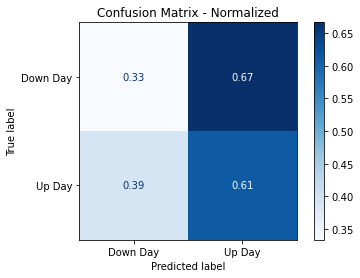

In [230]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(Y_test, Y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(RF2, X_test, Y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

In [ ]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

In [ ]:
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8)
plt.show()